1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Initial Prediction (Zebra as Horse): [[0.4353327]]


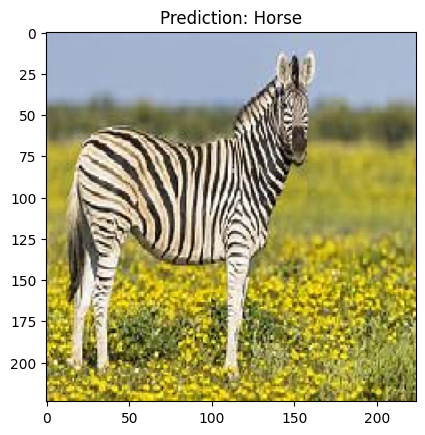

Found 21 images belonging to 2 classes.
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.4762 - loss: 0.6876
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 0.5238 - loss: 0.6707
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.5714 - loss: 0.6588
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.6190 - loss: 0.6412
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.6190 - loss: 0.6235
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Prediction After Fine-tuning (Zebra as Zebra): [[0.98551244]]


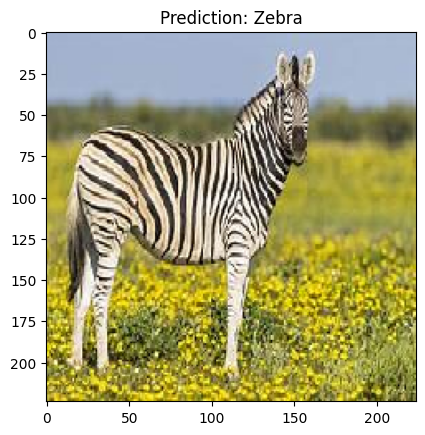

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

# Load the pre-trained VGG16 model without the top layer (classification layer)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model to avoid updates during initial training
base_model.trainable = False

# Add custom top layers for zebra vs horse classification
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)  # Pool the features
x = layers.Dense(1024, activation='relu')(x)  # Fully connected layer
x = layers.Dense(1, activation='sigmoid')(x)  # Output layer (1 for binary classification)

# Create the final model
model = models.Model(inputs=base_model.input, outputs=x)

# Compile the model (we'll train only the new top layers at first)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Prepare an image of a zebra (for demonstration) and process it for prediction
img_path = '/content/drive/MyDrive/deep learning/th.jpg'  # Replace with path to zebra image
img = image.load_img(img_path, target_size=(224, 224))  # Resize the image
img_array = image.img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = tf.keras.applications.vgg16.preprocess_input(img_array)  # Preprocess input for VGG16

# Predict the image (this will initially misclassify zebra as horse)
initial_prediction = model.predict(img_array)
print(f"Initial Prediction (Zebra as Horse): {initial_prediction}")
plt.imshow(img)
plt.title(f"Prediction: {'Zebra' if fine_tuned_prediction[0] > 0.5 else 'Horse'}")
plt.show()

# Fine-tuning the model
# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Example Data Augmentation and Generator Setup (replace with actual dataset)
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=20)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/deep learning/images of h&z',  # Replace with your directory containing 'horses' and 'zebras'
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')  # binary for 2 classes (horse and zebra)

# Fine-tune the model (train on new data)
model.fit(train_generator, epochs=5)

# Now, make the prediction again after fine-tuning
fine_tuned_prediction = model.predict(img_array)
print(f"Prediction After Fine-tuning (Zebra as Zebra): {fine_tuned_prediction}")

# Visualizing the result
plt.imshow(img)
plt.title(f"Prediction: {'Zebra' if fine_tuned_prediction[0] > 0.5 else 'Horse'}")
plt.show()

# Save the fine-tuned model
model.save('fine_tuned_zebra_horse_model.h5')


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np

In [ ]:
# Load CIFAR-10 dataset (simple dataset with 10 classes including 'dog' and 'cat')
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# Preprocess the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [ ]:
# Create Image Data Generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(x_train)

In [ ]:
# Define input shape
input_shape = x_train.shape[1:]

In [ ]:
# PART 1: Pre-trained model as a feature extractor (Freeze all layers)
def pretrained_feature_extractor():
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze all layers
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# PART 2: Train top layers and freeze the rest
def train_top_layers():
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze base layers
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# PART 3: Fine-tune the model parameters of a deep network (unfreeze top layers)
def fine_tune_model():
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = True  # Unfreeze the base model layers

    # Fine-tune deeper layers by freezing the first few layers
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# PART 4: Train a model from scratch
def train_scratch_model():
    model = Sequential([
        VGG16(include_top=False, weights=None, input_shape=input_shape),  # No pre-trained weights
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Choose which part you want to train
model_type = "pretrained"  # options: 'pretrained', 'top_layers', 'fine_tune', 'scratch'

if model_type == "pretrained":
    model = pretrained_feature_extractor()
elif model_type == "top_layers":
    model = train_top_layers()
elif model_type == "fine_tune":
    model = fine_tune_model()
elif model_type == "scratch":
    model = train_scratch_model()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Training the model
batch_size = 64
epochs = 1
model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
          validation_data=(x_test, y_test),
          epochs=epochs)

# Save the model
model.save('transfer_learning_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 738s 941ms/step - accuracy: 0.3475 - loss: 1.8275 - val_accuracy: 0.5191 - val_loss: 1.3749


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
The image is predicted as a horse.


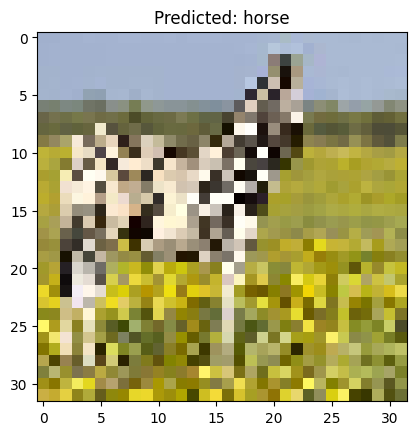

In [ ]:
# PART 5: Inference - Predict on a new image
def predict_image(image_path):
    from tensorflow.keras.preprocessing import image
    import matplotlib.pyplot as plt

    img = image.load_img(image_path, target_size=(32, 32))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    predicted_class = np.argmax(predictions, axis=-1)[0]
    print(f"The image is predicted as a {class_names[predicted_class]}.")

    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_class]}")
    plt.show()

predict_image("/content/drive/MyDrive/deep learning/th.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
The image is predicted as a horse.


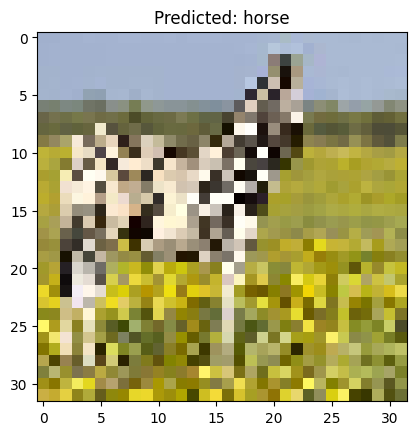

In [ ]:
fine_tune_model()
predict_image("/content/drive/MyDrive/deep learning/th.jpg")

In [ ]:
for layer in model.layers[-4:]:
    layer.trainable = True

# Recompile the model with a lower learning rate to avoid large updates
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training the model
model.fit(train_generator, epochs=10)

# Save the fine-tuned model
model.save('fine_tuned_model.h5')

NameError: name 'train_generator' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')